In [79]:
!pip3 install matplotlib
!pip3 install seaborn

In [112]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [113]:
from nrclex import NRCLex
import seaborn as sns
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

In [118]:
url = 'https://raw.githubusercontent.com/timhalter/PA-Addee/main/children_stories.Csv'
df = pd.read_csv(url,encoding='ISO-8859-1')



In [122]:
def process_text(text):
    
    # Remove digits
    text = re.sub(r'\d+', ' ', text)
    
    # Split on whitespace
    text = text.split()
    
    # Join on whitespace, but only the words that are not stop words
    text = ' '.join([word for word in text if word not in stopwords.words('english')])
        
    return text

df['desc'] = df['desc'].apply(lambda x: ''.join(re.sub(r'\W', ' ', x)))
df['desc'] = df['desc'].apply(lambda x: ''.join(re.sub(r'\s+', ' ', x, flags=re.I)))
df['desc'] = df['desc'].str.lower()
df['desc'] = df['desc'].copy().apply(process_text)

In [123]:
df.head()

,names,cats,desc
0,HIDE AND SEEK,Age 2-9,another game hide seek first fell deep dark ho...
1,GINGER THE GIRAFFE,Age 2-9,read warm tale camaraderie affection set wild ...
2,DOING MY CHORES,Age 2-9,love shines great illustrated kidsâ book read ...
3,ABE THE SERVICE DOG,Age 2-9,abe real service dog dedicated life assisting ...
4,SUNNY MEADOWS WOODLAND SCHOOL,Age 2-9,class took little train went deep woods first ...


In [124]:
text = df['desc'].iloc[0] # erste zeile 
emotion = NRCLex(text)
freq = emotion.affect_frequencies
#print('\n', emotion.words)
print('\n', emotion.affect_dict)
print('\n', emotion.raw_emotion_scores)
print('\n', emotion.top_emotions)
print('\n', emotion.affect_frequencies)


 {'hide': ['fear'], 'seek': ['anticipation'], 'fell': ['negative', 'sadness'], 'dark': ['sadness'], 'ground': ['trust'], 'found': ['joy', 'positive', 'trust'], 'treasure': ['anticipation', 'joy', 'positive', 'trust'], 'thrilling': ['anticipation', 'joy', 'positive', 'surprise'], 'adventure': ['anticipation', 'positive'], 'sally': ['surprise'], 'fun': ['anticipation', 'joy', 'positive']}

 {'fear': 1, 'anticipation': 5, 'negative': 1, 'sadness': 2, 'trust': 3, 'joy': 4, 'positive': 5, 'surprise': 2}

 [('positive', 0.21739130434782608), ('anticipation', 0.21739130434782608)]

 {'fear': 0.043478260869565216, 'anger': 0.0, 'anticip': 0.0, 'trust': 0.13043478260869565, 'surprise': 0.08695652173913043, 'positive': 0.21739130434782608, 'negative': 0.043478260869565216, 'sadness': 0.08695652173913043, 'disgust': 0.0, 'joy': 0.17391304347826086, 'anticipation': 0.21739130434782608}


In [60]:
for emotion in freq.values():
    print(emotion)

0.045454545454545456
0.0
0.0
0.13636363636363635
0.045454545454545456
0.22727272727272727
0.045454545454545456
0.09090909090909091
0.0
0.18181818181818182
0.22727272727272727


In [39]:
df.head()

,Title,Author,Desc,Inerest_age,Reading_age
0,The Girl Who Drank the Moon,Kelly Barnhill,"Every year, the evil Protectorate offers a bab...",10-14,10-14
1,Time Between Us,Tamara Ireland Stone,Sixteen-year-old Anna is struggling to underst...,13+,12+
2,Girl Out of Water,Nat Luurtsema,Lou Brown's swimming ambitions sank without tr...,13-18,10+
3,Captive,A J Grainger,Robyn is scared. Ever since the attempted assa...,13+,13
4,The School of Music,Rachel Bowen and Meurig Bowen Illustrator: Dan...,Welcome to the School of Music. In charge is M...,10+,10+


1. Listen machen für jede Emotion (10 total)
2. Durch jede Zeile loopen \
Im Loop: \
2a. Emotions 'frequencies' für die Beschreibung der aktuellen Zeile holen (siehe weiter oben für Format), 
    das resultierende Objekt in 'emotion' ist vom Typ 'Counter()' \
2b. Die Funktion getEmotionFreq() wird aufgerufen um die 10 verschiedenen Emotions-Werte in einem numpy array zu           speichern und zurückzugeben. 
3. Die einzelnen Werte des numpy Arrays 'emotions' werden zu den ensprechenden listen hinzugefügt
4. Nach dem Loop werden für jede Emotionskategorie eine neue Spalte im Dataframe ersellt und mit den Werten                initialisiert.

In [125]:
def getEmotionFreq(emotion):
  eArr = np.zeros(11)
  for i, val in enumerate(emotion.values()):
    eArr[i] = val
  return eArr

fear = []
anger = []
trust = []
surprise = []
positive = []
negative = []
sadness = []
disgust = []
joy = []
anticipation = []

for idx, row in df.iterrows():
  text = row['desc']
  emotion = NRCLex(text).affect_frequencies
  emotions = getEmotionFreq(emotion)
  
  fear.append(emotions[0])
  anger.append(emotions[1])
  trust.append(emotions[3])
  surprise.append(emotions[4])
  positive.append(emotions[5])
  negative.append(emotions[6])
  sadness.append(emotions[7])
  disgust.append(emotions[8])
  joy.append(emotions[9])
  anticipation.append(emotions[10])

df['fear'] = fear
df['anger'] = anger
df['trust'] = trust
df['surprise'] = surprise
df['positive'] = positive
df['negative'] = negative
df['sadness'] = sadness
df['disgust'] = disgust
df['joy'] = joy
df['anticipation'] = anticipation
df.head(10)


,names,cats,desc,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
0,HIDE AND SEEK,Age 2-9,another game hide seek first fell deep dark ho...,0.043478,0.000000,0.130435,0.086957,0.217391,0.043478,0.086957,0.000000,0.173913,0.217391
1,GINGER THE GIRAFFE,Age 2-9,read warm tale camaraderie affection set wild ...,0.125000,0.000000,0.125000,0.062500,0.312500,0.062500,0.000000,0.000000,0.187500,0.125000
2,DOING MY CHORES,Age 2-9,love shines great illustrated kidsâ book read ...,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333
3,ABE THE SERVICE DOG,Age 2-9,abe real service dog dedicated life assisting ...,0.000000,0.000000,0.250000,0.050000,0.400000,0.000000,0.000000,0.000000,0.150000,0.150000
4,SUNNY MEADOWS WOODLAND SCHOOL,Age 2-9,class took little train went deep woods first ...,0.090909,0.000000,0.181818,0.181818,0.181818,0.090909,0.000000,0.000000,0.090909,0.181818
5,TOOTH FAIRY,Age 2-9,wonderful story weaves magic childâ imaginatio...,0.000000,0.000000,0.181818,0.090909,0.272727,0.000000,0.000000,0.000000,0.181818,0.272727
6,HAMMY THE HAMSTER,Age 2-9,heâ got swag wears tux heâ hipster hamster lik...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,THE CASE OF THE MISSING SMILE,Age 2-9,detective peterson trying find sally sue lost ...,0.000000,0.055556,0.111111,0.166667,0.222222,0.166667,0.111111,0.000000,0.166667,0.000000
8,HOMEWORK - YUCK!,Age 2-9,jamal made case next open house mattered much ...,0.066667,0.000000,0.266667,0.066667,0.333333,0.066667,0.066667,0.000000,0.066667,0.066667
9,CAPTAIN FANTASTIC,Age 2-9,dr zobâ evil plans failed thanks wonder dog wi...,0.055556,0.055556,0.111111,0.111111,0.277778,0.055556,0.055556,0.055556,0.166667,0.055556


In [126]:
df = df.drop(df.query("cats == 'Age '").index, axis=0).reset_index(drop=True)

def min_age(sir):
    if sir.find('+')!=-1:
        if sir.find('months+')!=-1:
          return np.int(sir[:sir.find('months+')])
        else:
          return np.int(sir[:sir.find('+')])
    elif sir.find('-')!=-1:
        return np.int(sir.split('-')[0])
    elif bool(re.match(r'[0-9]+',sir)):
        return np.int(sir)
    else:
        return 'else'
def max_age(sir):
    if sir.find('+')!=-1:
        return 99
    elif sir.find('-')!=-1:
        return np.int(sir.split('-')[1])
    elif bool(re.match(r'[0-9]+',sir)):
        return np.int(sir)
    else:
        return 'else'

df['cats'] = df['cats'].str.replace('Age ', '')
df['Min_Age'] = df.cats.apply(min_age)
df['Max_Age'] = df.cats.apply(max_age)
df.head()

<ipython-input-126-6897a52fa15c>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.int(sir.split('-')[0])
<ipython-input-126-6897a52fa15c>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for 

,names,cats,desc,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,Min_Age,Max_Age
0,HIDE AND SEEK,2-9,another game hide seek first fell deep dark ho...,0.043478,0.0,0.130435,0.086957,0.217391,0.043478,0.086957,0.0,0.173913,0.217391,2,9
1,GINGER THE GIRAFFE,2-9,read warm tale camaraderie affection set wild ...,0.125000,0.0,0.125000,0.062500,0.312500,0.062500,0.000000,0.0,0.187500,0.125000,2,9
2,DOING MY CHORES,2-9,love shines great illustrated kidsâ book read ...,0.000000,0.0,0.000000,0.000000,0.333333,0.000000,0.000000,0.0,0.333333,0.333333,2,9
3,ABE THE SERVICE DOG,2-9,abe real service dog dedicated life assisting ...,0.000000,0.0,0.250000,0.050000,0.400000,0.000000,0.000000,0.0,0.150000,0.150000,2,9
4,SUNNY MEADOWS WOODLAND SCHOOL,2-9,class took little train went deep woods first ...,0.090909,0.0,0.181818,0.181818,0.181818,0.090909,0.000000,0.0,0.090909,0.181818,2,9


In [127]:
df.drop('cats', axis=1, inplace=True)
df.drop('Max_Age', axis=1, inplace=True)

In [65]:
df.to_csv('df_Addee.csv', index=False)

In [129]:
df_emotions = df.groupby('Min_Age').describe()   # .to_csv('emotion_data.csv', index=False)
df_emotions

fear                                                              \
        count      mean       std       min       25%       50%       75%   
Min_Age                                                                     
0        52.0  0.024791  0.039032  0.000000  0.000000  0.000000  0.052632   
1        19.0  0.055343  0.073520  0.000000  0.000000  0.016949  0.133929   
2        53.0  0.052468  0.060805  0.000000  0.000000  0.041667  0.076923   
3        54.0  0.056154  0.061107  0.000000  0.000000  0.038462  0.088670   
4        30.0  0.057678  0.053023  0.000000  0.023611  0.047619  0.082908   
5        22.0  0.036304  0.054543  0.000000  0.000000  0.000000  0.047704   
6        28.0  0.044725  0.050960  0.000000  0.000000  0.033908  0.084559   
7        36.0  0.064657  0.047417  0.000000  0.035119  0.045455  0.100281   
8        31.0  0.064514  0.042888  0.000000  0.039352  0.054054  0.101282   
9        40.0  0.079029  0.044520  0.000000  0.043478  0.076197  0.111111   
10       27.0  0.096269  0.051520  0.000000  0.066398  0.100000  0.123340   
11       21.0  0.099924  0.046445  0.000000  0.071429  0.102041  0.130435   
12       12.0  0.081174  0.043495  0.037037  0.048682  0.056873  0.119981   
13        3.0  0.081952  0.030651  0.050000  0.067373  0.084746  0.097928   

                  anger            ...       joy           anticipation  \
              max count      mean  ...       75%       max        count   
Min_Age                            ...                                    
0        0.136364  52.0  0.021649  ...  0.250000  0.400000         52.0   
1        0.200000  19.0  0.036914  ...  0.196774  0.277778         19.0   
2        0.217391  53.0  0.029946  ...  0.190476  0.333333         53.0   
3        0.250000  54.0  0.031860  ...  0.198387  0.280000         54.0   
4        0.214286  30.0  0.050494  ...  0.192036  0.250000         30.0   
5        0.190476  22.0  0.021965  ...  0.194872  0.250000         22.0   
6        0.173913  28.0  0.043112  ...  0.186364  0.250000         28.0   
7        0.166667  36.0  0.038589  ...  0.143728  0.250000         36.0   
8        0.152542  31.0  0.047448  ...  0.165152  0.222222         31.0   
9        0.178082  40.0  0.051724  ...  0.123888  0.333333         40.0   
10       0.190476  27.0  0.065721  ...  0.115385  0.159420         27.0   
11       0.195652  21.0  0.056189  ...  0.122449  0.214286         21.0   
12       0.166667  12.0  0.051037  ...  0.126008  0.148148         12.0   
13       0.111111   3.0  0.070935  ...  0.078625  0.101695          3.0   

                                                                               
             mean       std       min       25%       50%       75%       max  
Min_Age                                                                        
0        0.140753  0.088158  0.000000  0.083333  0.136111  0.200000  0.333333  
1        0.159772  0.078361  0.000000  0.122024  0.166667  0.206897  0.285714  
2        0.131322  0.143554  0.000000  0.066667  0.113636  0.157895  1.000000  
3        0.127616  0.053294  0.000000  0.089891  0.133333  0.152542  0.272727  
4        0.129461  0.060793  0.000000  0.112554  0.131183  0.155128  0.250000  
5        0.128347  0.057589  0.037037  0.083929  0.123724  0.165323  0.250000  
6        0.119610  0.080133  0.000000  0.074695  0.121822  0.174552  0.333333  
7        0.104572  0.058803  0.000000  0.074074  0.097561  0.140365  0.250000  
8        0.112854  0.054406  0.000000  0.082763  0.125000  0.151852  0.216216  
9        0.113843  0.055756  0.000000  0.082615  0.106137  0.143908  0.260870  
10       0.105710  0.051148  0.025000  0.066229  0.111111  0.131183  0.238095  
11       0.102587  0.064684  0.000000  0.057143  0.102041  0.142857  0.250000  
12       0.129040  0.033136  0.079365  0.103338  0.123638  0.162634  0.171429  
13       0.080100  0.022583  0.055556  0.070151  0.084746  0.092373  0.100000  

[14 rows x 80 columns]

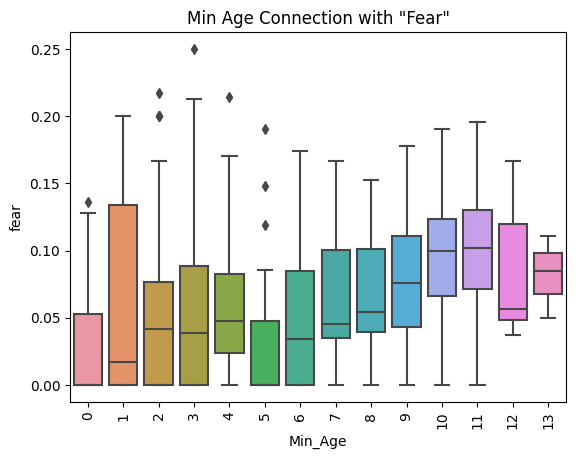

In [130]:


plt.title('Min Age Connection with "Fear"')
ax = sns.boxplot(y=df['fear'],x=df['Min_Age'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()



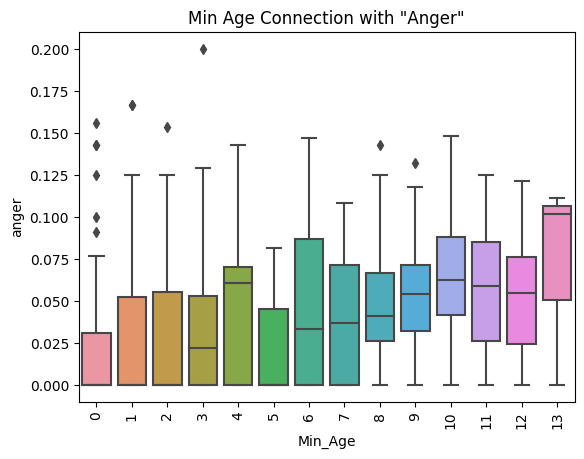

In [131]:
plt.title('Min Age Connection with "Anger"')
ax = sns.boxplot(y=df['anger'],x=df['Min_Age'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

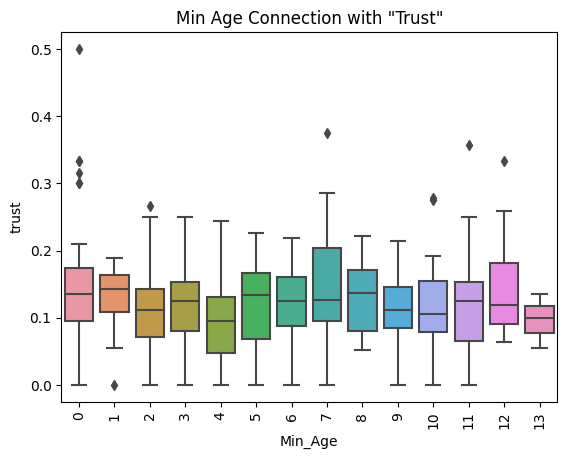

In [132]:
plt.title('Min Age Connection with "Trust"')
ax = sns.boxplot(y=df['trust'],x=df['Min_Age'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

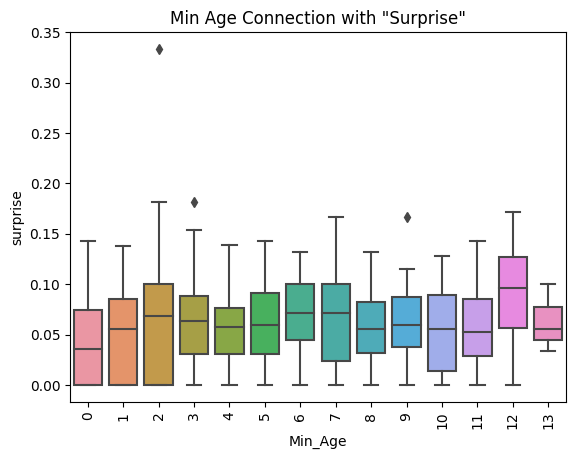

In [133]:
plt.title('Min Age Connection with "Surprise"')
ax = sns.boxplot(y=df['surprise'],x=df['Min_Age'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

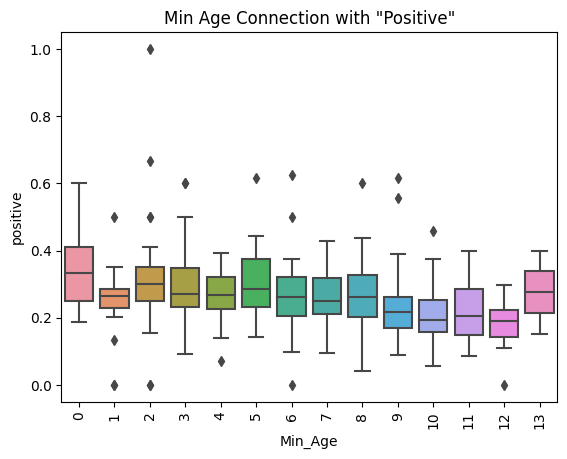

In [134]:
plt.title('Min Age Connection with "Positive"')
ax = sns.boxplot(y=df['positive'],x=df['Min_Age'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

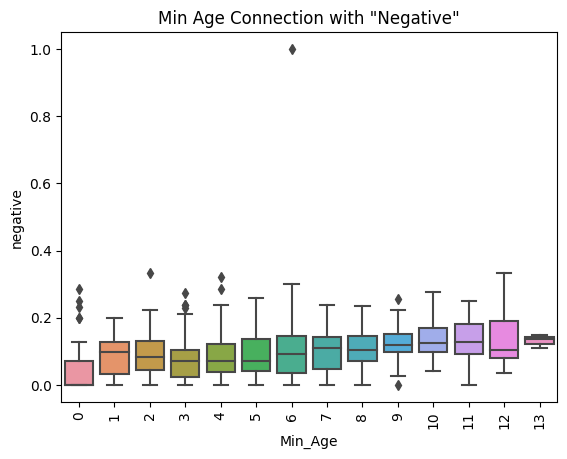

In [135]:
plt.title('Min Age Connection with "Negative"')
ax = sns.boxplot(y=df['negative'],x=df['Min_Age'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

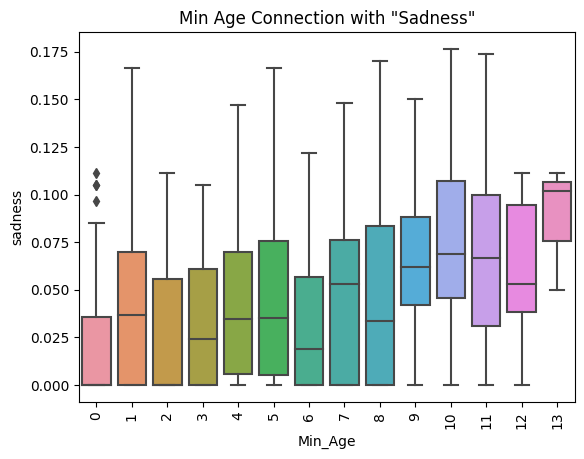

In [136]:
plt.title('Min Age Connection with "Sadness"')
ax = sns.boxplot(y=df['sadness'],x=df['Min_Age'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show() 

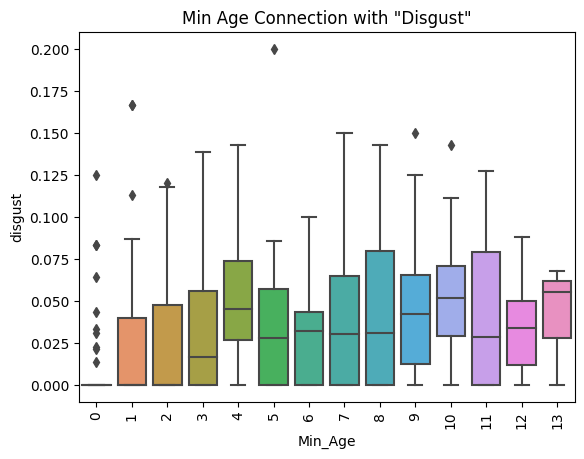

In [137]:
plt.title('Min Age Connection with "Disgust"')
ax = sns.boxplot(y=df['disgust'],x=df['Min_Age'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show() 

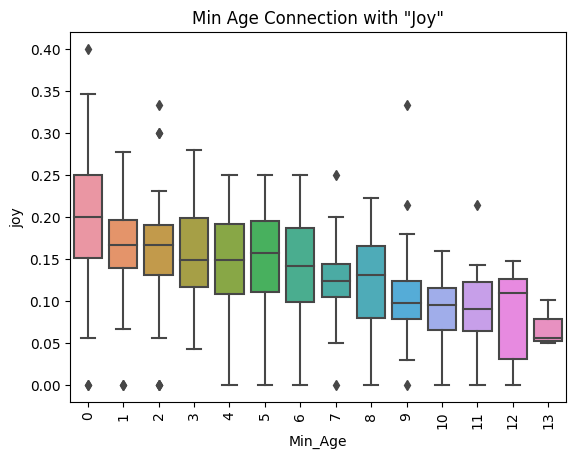

In [138]:
plt.title('Min Age Connection with "Joy"')
ax = sns.boxplot(y=df['joy'],x=df['Min_Age'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show() 

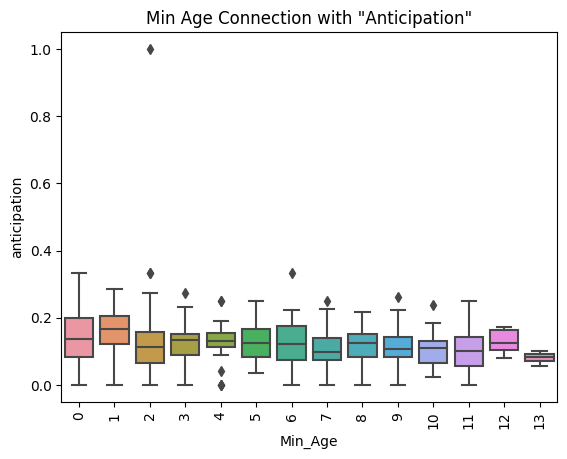

In [139]:
plt.title('Min Age Connection with "Anticipation"')
ax = sns.boxplot(y=df['anticipation'],x=df['Min_Age'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show() 

Anhand der obigen Plots sind einige Korrelationen zu erkennen. Vorallem bei den Emotionen 'Fear', 'Sadness' und 'Joy' kann man klare Unterschiede bei den verschiedenen Altersklassen erkennen. \
In einem nächsten Schritt fokussieren wir uns aussschliesslich auf diese drei Emotionen und versuchen mithilfe der nachfolgenden Plots tresholds für die verschiedenen Altersklassen zu definieren. 

In [162]:
# Irrelevante Spalten entfernen
df_copy = df.copy()
df_copy.drop(['anger', 'trust','surprise','positive','negative','disgust','anticipation'], axis=1, inplace=True)

In [163]:
df_age0 = df_copy[df_copy['Min_Age']==0]
df_age1 = df_copy[df_copy['Min_Age']==1]
df_age2 = df_copy[df_copy['Min_Age']==2]
df_age3 = df_copy[df_copy['Min_Age']==3]
df_age4 = df_copy[df_copy['Min_Age']==4]
df_age5 = df_copy[df_copy['Min_Age']==5]
df_age6 = df_copy[df_copy['Min_Age']==6]
df_age7 = df_copy[df_copy['Min_Age']==7]
df_age8 = df_copy[df_copy['Min_Age']==8]
df_age9 = df_copy[df_copy['Min_Age']==9]
df_age10 = df_copy[df_copy['Min_Age']==10]
df_age11 = df_copy[df_copy['Min_Age']==11]
df_age12 = df_copy[df_copy['Min_Age']==12]
df_age13 = df_copy[df_copy['Min_Age']==13]

In [164]:
df_age0.drop('Min_Age', axis=1, inplace=True)
df_age1.drop('Min_Age', axis=1, inplace=True)
df_age2.drop('Min_Age', axis=1, inplace=True)
df_age3.drop('Min_Age', axis=1, inplace=True)
df_age4.drop('Min_Age', axis=1, inplace=True)
df_age5.drop('Min_Age', axis=1, inplace=True)
df_age6.drop('Min_Age', axis=1, inplace=True)
df_age7.drop('Min_Age', axis=1, inplace=True)
df_age8.drop('Min_Age', axis=1, inplace=True)
df_age9.drop('Min_Age', axis=1, inplace=True)
df_age10.drop('Min_Age', axis=1, inplace=True)
df_age11.drop('Min_Age', axis=1, inplace=True)
df_age12.drop('Min_Age', axis=1, inplace=True)
df_age13.drop('Min_Age', axis=1, inplace=True)


C:\Users\tiimh\anaconda3\envs\tensorflow\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


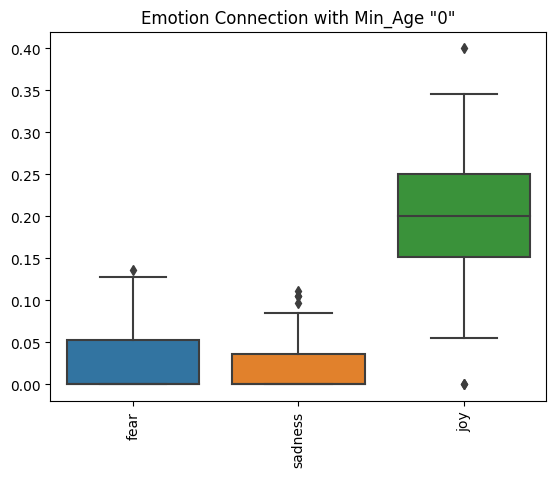

In [165]:
plt.title('Emotion Connection with Min_Age "0"')
ax = sns.boxplot(data=df_age0)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [188]:
df_age0.describe()

,fear,sadness,joy
count,52.000000,52.000000,52.000000
mean,0.024791,0.022186,0.193116
std,0.039032,0.034794,0.077635
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.151364
50%,0.000000,0.000000,0.200000
75%,0.052632,0.035638,0.250000
max,0.136364,0.111111,0.400000


In [ ]:
plt.title('Emotion Connection with Min_Age "1"')
ax = sns.boxplot(data=df_age1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [197]:
df_age1.describe()

,fear,sadness,joy
count,19.000000,19.000000,19.000000
mean,0.055343,0.047958,0.151767
std,0.073520,0.055869,0.068948
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.139225
50%,0.016949,0.037037,0.166667
75%,0.133929,0.069613,0.196774
max,0.200000,0.166667,0.277778


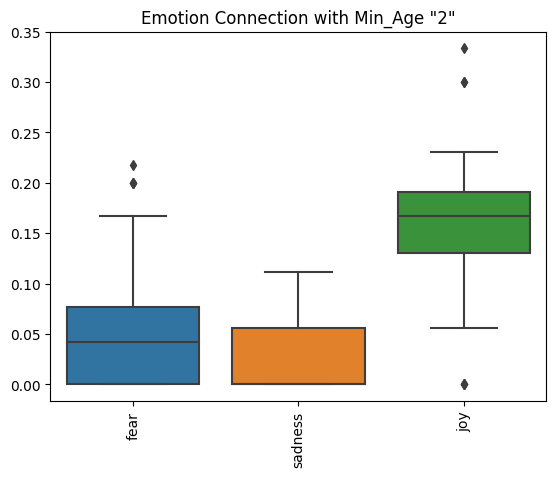

In [205]:
plt.title('Emotion Connection with Min_Age "2"')
ax = sns.boxplot(data=df_age2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [201]:
df_age2.describe()

,fear,sadness,joy
count,53.000000,53.000000,53.000000
mean,0.052468,0.029193,0.159765
std,0.060805,0.034924,0.064829
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.130435
50%,0.041667,0.000000,0.166667
75%,0.076923,0.055556,0.190476
max,0.217391,0.111111,0.333333


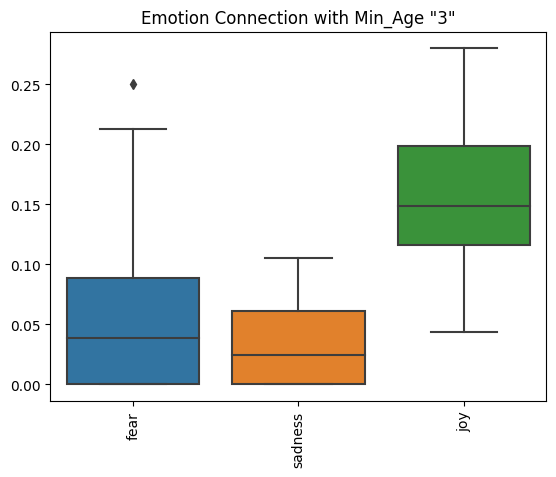

In [210]:
plt.title('Emotion Connection with Min_Age "3"')
ax = sns.boxplot(data=df_age3)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [206]:
df_age3.describe()

,fear,sadness,joy
count,54.000000,54.000000,54.000000
mean,0.056154,0.031303,0.159735
std,0.061107,0.032509,0.063275
min,0.000000,0.000000,0.043478
25%,0.000000,0.000000,0.116389
50%,0.038462,0.024128,0.148511
75%,0.088670,0.061161,0.198387
max,0.250000,0.105263,0.280000


In [ ]:
plt.title('Emotion Connection with Min_Age "4"')
ax = sns.boxplot(data=df_age4)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [211]:
df_age4.describe()

,fear,sadness,joy
count,30.000000,30.000000,30.000000
mean,0.057678,0.045642,0.148061
std,0.053023,0.041421,0.059916
min,0.000000,0.000000,0.000000
25%,0.023611,0.005556,0.108135
50%,0.047619,0.034524,0.149206
75%,0.082908,0.069805,0.192036
max,0.214286,0.147059,0.250000


In [ ]:
plt.title('Emotion Connection with Min_Age "5"')
ax = sns.boxplot(data=df_age5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [216]:
df_age5.describe()

,fear,sadness,joy
count,22.000000,22.000000,22.000000
mean,0.036304,0.046992,0.151336
std,0.054543,0.045928,0.066231
min,0.000000,0.000000,0.000000
25%,0.000000,0.005102,0.111111
50%,0.000000,0.035185,0.157333
75%,0.047704,0.075625,0.194872
max,0.190476,0.166667,0.250000


In [ ]:
plt.title('Emotion Connection with Min_Age "6"')
ax = sns.boxplot(data=df_age6)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [220]:
df_age6.describe()

,fear,sadness,joy
count,28.000000,28.000000,28.000000
mean,0.044725,0.033091,0.144075
std,0.050960,0.039882,0.063376
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.099390
50%,0.033908,0.018891,0.142136
75%,0.084559,0.056715,0.186364
max,0.173913,0.121951,0.250000


In [ ]:
plt.title('Emotion Connection with Min_Age "7"')
ax = sns.boxplot(data=df_age7)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [173]:
df_age7.describe()

,fear,sadness,joy
count,36.000000,36.000000,36.000000
mean,0.064657,0.050202,0.126302
std,0.047417,0.044944,0.044501
min,0.000000,0.000000,0.000000
25%,0.035119,0.000000,0.104787
50%,0.045455,0.053090,0.124298
75%,0.100281,0.076389,0.143728
max,0.166667,0.148148,0.250000


In [ ]:
plt.title('Emotion Connection with Min_Age "8"')
ax = sns.boxplot(data=df_age8)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [174]:
df_age8.describe()

,fear,sadness,joy
count,31.000000,31.000000,31.000000
mean,0.064514,0.051580,0.120247
std,0.042888,0.050232,0.059327
min,0.000000,0.000000,0.000000
25%,0.039352,0.000000,0.079557
50%,0.054054,0.033708,0.131579
75%,0.101282,0.083333,0.165152
max,0.152542,0.170213,0.222222


In [ ]:
plt.title('Emotion Connection with Min_Age "9"')
ax = sns.boxplot(data=df_age9)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [175]:
df_age9.describe()

,fear,sadness,joy
count,40.000000,40.000000,40.000000
mean,0.079029,0.062812,0.104972
std,0.044520,0.036261,0.055691
min,0.000000,0.000000,0.000000
25%,0.043478,0.041964,0.078431
50%,0.076197,0.061862,0.097168
75%,0.111111,0.088498,0.123888
max,0.178082,0.150000,0.333333


In [ ]:
plt.title('Emotion Connection with Min_Age "10"')
ax = sns.boxplot(data=df_age10)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [176]:
df_age10.describe()

,fear,sadness,joy
count,27.000000,27.000000,27.000000
mean,0.096269,0.072907,0.090186
std,0.051520,0.047817,0.041246
min,0.000000,0.000000,0.000000
25%,0.066398,0.045549,0.065733
50%,0.100000,0.068966,0.095238
75%,0.123340,0.107280,0.115385
max,0.190476,0.176471,0.159420


In [ ]:
plt.title('Emotion Connection with Min_Age "11"')
ax = sns.boxplot(data=df_age11)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [177]:
df_age11.describe()

,fear,sadness,joy
count,21.000000,21.000000,21.000000
mean,0.099924,0.066944,0.092473
std,0.046445,0.047335,0.045924
min,0.000000,0.000000,0.000000
25%,0.071429,0.031250,0.063830
50%,0.102041,0.066667,0.090909
75%,0.130435,0.100000,0.122449
max,0.195652,0.173913,0.214286


In [ ]:
plt.title('Emotion Connection with Min_Age "12"')
ax = sns.boxplot(data=df_age12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [178]:
df_age12.describe()

,fear,sadness,joy
count,12.000000,12.000000,12.000000
mean,0.081174,0.059938,0.085827
std,0.043495,0.039553,0.052533
min,0.037037,0.000000,0.000000
25%,0.048682,0.038603,0.031385
50%,0.056873,0.052962,0.109235
75%,0.119981,0.094498,0.126008
max,0.166667,0.111111,0.148148


In [ ]:
plt.title('Emotion Connection with Min_Age "13"')
ax = sns.boxplot(data=df_age13)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [179]:
df_age13.describe()

,fear,sadness,joy
count,3.000000,3.000000,3.000000
mean,0.081952,0.087602,0.069083
std,0.030651,0.032903,0.028379
min,0.050000,0.050000,0.050000
25%,0.067373,0.075847,0.052778
50%,0.084746,0.101695,0.055556
75%,0.097928,0.106403,0.078625
max,0.111111,0.111111,0.101695
